In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import pysm3 as pysm
import pysm3.units as u

In [6]:
nside = 2048
lmax = 2048

In [7]:
datadir=Path("data/")

In [8]:
planck_mask_filename = datadir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

if not planck_mask_filename.exists():
    !wget -O $planck_mask_filename "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

In [9]:
galplane_mask = hp.read_map(planck_mask_filename, ["GAL097"])

`dust_gnilc_logpoltens_varres_nomono.fits` is produced by the GNILC templates notebook:

* <https://pysm3.readthedocs.io/en/latest/preprocess-templates/gnilc_dust_logpoltens_templates.html>

In [10]:
log_pol_tens_varres = pysm.read_map("dust_gnilc/raw/dust_gnilc_logpoltens_varres_nomono.fits", nside=2048, field=(0,1,2)).value.astype(np.float64)

No physical unit associated with file /global/project/projectdirs/cmb/www/pysm-data/dust_gnilc/raw/dust_gnilc_logpoltens_varres_nomono.fits


In [11]:
(galplane_mask == 1 ).sum()/len(galplane_mask)

0.7580817937850952

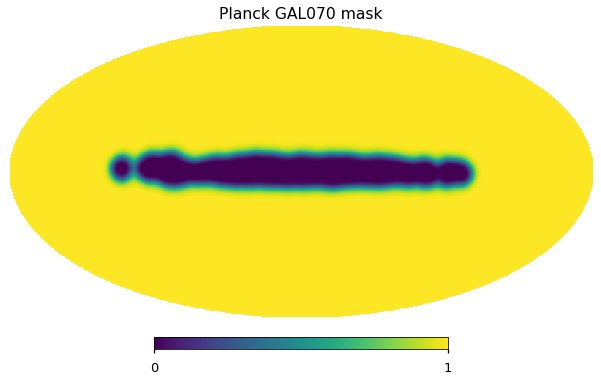

In [12]:
hp.mollview(galplane_mask, title="Planck GAL070 mask")

In [13]:
preproc_log_pol_tens_varres = log_pol_tens_varres.copy()
for comp in preproc_log_pol_tens_varres:
    comp[galplane_mask == 1] = 0

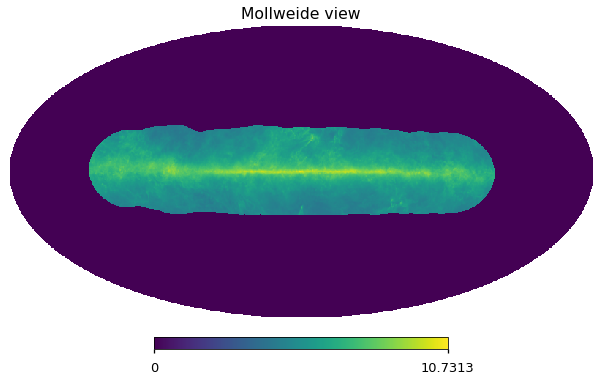

In [14]:
hp.mollview(preproc_log_pol_tens_varres[0])

In [15]:
galplane_mask = galplane_mask.astype(np.float64)

In [16]:
hp.write_map(datadir / "gnilc_dust_galplane.fits",list(preproc_log_pol_tens_varres) + [galplane_mask],   coord="G", column_units=["muK_RJ"]*3+[""],
             column_names=["TEMPERATURE", "Q_POLARISATION", "U_POLARISATION", "GALMASK"], dtype=np.float32)